In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
from scipy.constants import c, pi
from diffraction import length, unit, D_s_h

In [23]:
def sign(x):
    if x < 0:
        return -1
    else:
        return 1


def E(x, f=2.45e9):

    # Wave constants
    l = c / f
    k = 2 * pi / l
    E = np.zeros(3, dtype=complex)

    # Diffraction constant parameters
    n = 2  # because alpha = 0
    beta_0 = pi / 2

    O = array([-2, 0, 0], dtype=float)  # TX point
    Q = array([0, 0, 1], dtype=float)  # Where diffraction occurs
    P = array([x, 0, 0], dtype=float)  # RX point

    alpha = np.arctan2(2, 1)

    theta_dir = -array([cos(alpha), 0, -sin(alpha)])

    e = array([0, 1, 0], dtype=float)  # Edge direction
    n0 = array([-1, 0, 0], dtype=float)  # Normal direction

    s_dir = unit(P - Q)
    s = length(P - Q)
    s_p_dir = unit(Q - O)
    s_p = length(Q - O)

    E_D = (exp(-1j * k * s_p) / s_p) * theta_dir

    sinb01 = np.linalg.norm(cross(s_p_dir, e))
    sinb02 = np.linalg.norm(cross(s_dir, e))
    assert (
        abs(sinb01 - sinb02) < 1e-6
    ), f"KELLER Cone is not satisfied with {sinb01} and {sinb02}"

    phi_p_dir = unit(-cross(e, s_p_dir))
    beta_0_p_dir = unit(+cross(phi_p_dir, s_p_dir))

    phi_dir = unit(cross(e, s_dir))
    beta_0_dir = unit(cross(phi_dir, s_dir))

    s_t_dir = unit(s_dir - dot(s_dir, e) * e)
    s_t_p_dir = unit(s_p_dir - dot(s_p_dir, e) * e)

    t = cross(n0, e)

    phi_p = pi - (pi - arccos(dot(-s_t_p_dir, t))) * sign(dot(-s_t_p_dir, n0))
    phi = pi - (pi - arccos(dot(s_t_dir, t))) * sign(dot(s_t_dir, n0))

    # Diffraction

    Li = Lro = Lrn = s * np.sin(beta_0) ** 2

    D_s, D_h = D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro)

    Ei = array([dot(E_D, beta_0_p_dir), dot(E_D, phi_p_dir)])

    D = array([[-D_s, 0], [0, -D_h]], dtype=complex64)

    rho = s_p
    factor = np.sqrt(rho / (s * (s + rho))) * np.exp(-1j * k * s)

    Ed = factor * (D @ Ei)

    E += Ed[0] * beta_0_dir + Ed[1] * phi_dir

    return E * np.cross(s_dir, [0, 1, 0])

0.47287080450158786
0.22360679774997896
0.44710885159837344
0.2153109507469318
0.42379778324873446
0.20749563590162515
0.4026510728276588
0.2001426675100923
0.3834117907295657
0.1932279835243867
0.36585389594962736
0.18672486488642215
0.3497804995655
0.1806059001565661
0.33502092082371643
0.17484415463413822
0.32142743869110624
0.1694138372308014
0.3088721628595464
0.1642906519911202
0.29724420224155507
0.1594519533904263
0.28644718577135964
0.15487678139853678
0.276397131313444
0.15054582477479864
0.2670206326853467
0.14644134344380125
0.25825332584050553
0.14254706948758958
0.2500385945044094
0.13884809900415088
0.24232647851181813
0.13533078238232338
0.23507275244671114
0.13198261751285836
0.22823814679616158
0.12879214850694215
0.2217876881636724
0.12574887124887854
0.2156901389335011
0.12284314632387718
0.20991752008179998
0.12006611937546825
0.20444470361559577
0.1174096486556112
0.199249063441297
0.11486623936555815
0.1943101753847084
0.11242898430186535
0.18960955866735243
0.11

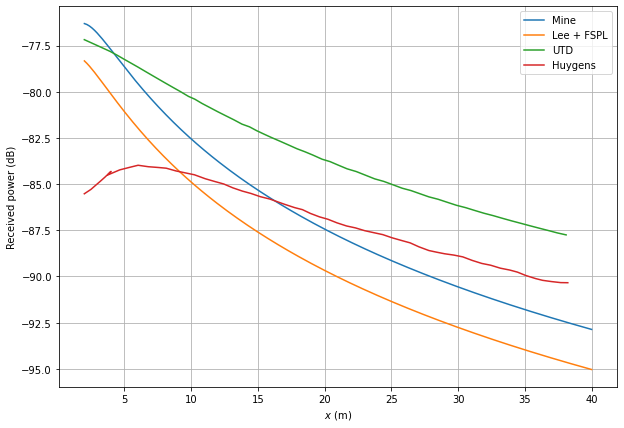

In [28]:
n = 200

x = np.linspace(2, 40, n)

plt.figure(figsize=(10, 7))

E1 = np.zeros((n, 3), dtype=complex64)

f = 2.45e9
l = c / f

for i in range(n):
    E1[i, :] = E(x[i], f=f)

E1 /= 4 * np.pi / l
P = 20 * np.log10(np.linalg.norm(E1, axis=1))
FSPL = -20 * np.log10((4 * np.pi * (np.sqrt(4 + 1) + np.sqrt(1 + x**2)) / l))
v = np.sqrt((2 + x) / (l * x))

PL = FSPL + 20 * np.log10(0.225 / v)

# P = P - max(P)

# P = P - 80
plt.plot(x, P, label="Mine")
plt.plot(x, PL, label="Lee + FSPL")

d, UTD = np.loadtxt("/home/eertmans/Downloads/UTD.csv", delimiter=",").T
plt.plot(d, UTD, label="UTD")

d, H = np.loadtxt("/home/eertmans/Downloads/huygens.csv", delimiter=",").T
plt.plot(d, H, label="Huygens")

plt.xlabel(r"$x$ (m)")
plt.ylabel(r"Received power (dB)")
plt.legend()
plt.grid("on")

In [ ]:
20 * np.log10(0.023)

In [26]:
FSPL

array([-53.24140487, -53.56978254, -53.89092557, -54.20431123,
       -54.50970447, -54.80706183, -55.09646623, -55.37808256,
       -55.65212732, -55.91884785, -56.17850803, -56.43137862,
       -56.6777306 , -56.91783082, -57.15193904, -57.38030615,
       -57.60317306, -57.82077017, -58.03331715, -58.241023  ,
       -58.44408628, -58.64269543, -58.83702914, -59.02725685,
       -59.21353917, -59.39602832, -59.57486864, -59.75019702,
       -59.9221433 , -60.0908307 , -60.25637625, -60.41889109,
       -60.57848087, -60.73524605, -60.88928222, -61.04068041,
       -61.18952731, -61.33590556, -61.47989399, -61.62156781,
       -61.76099884, -61.8982557 , -62.03340398, -62.16650643,
       -62.29762309, -62.42681145, -62.55412661, -62.67962136,
       -62.80334634, -62.92535015, -63.04567944, -63.16437903,
       -63.28149197, -63.39705967, -63.51112196, -63.62371717,
       -63.73488218, -63.84465255, -63.95306253, -64.06014512,
       -64.16593218, -64.27045442, -64.3737415 , -64.47

In [32]:
s_p = array([2, 0, 1], dtype=float)
s_p /= np.linalg.norm(s_p)
n1 = array([-1, 0, 0], dtype=float)
n2 = array([+1, 0, 0], dtype=float)

In [33]:
dot(s_p, n1)

-0.8944271909999159

In [34]:
dot(s_p, n2)

0.8944271909999159